<a href="https://colab.research.google.com/github/ashokpdr/Foecasting/blob/main/oncology_sales__forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwgky3bcj/0wbbzlw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwgky3bcj/_b65y22x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34526', 'data', 'file=/tmp/tmpwgky3bcj/0wbbzlw4.json', 'init=/tmp/tmpwgky3bcj/_b65y22x.json', 'output', 'file=/tmp/tmpwgky3bcj/prophet_model502z1a1x/prophet_model-20250202075241.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:52:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Forecast MAPE: 5.56%
Tuned XGBoost Forecast MAPE: 8.37%


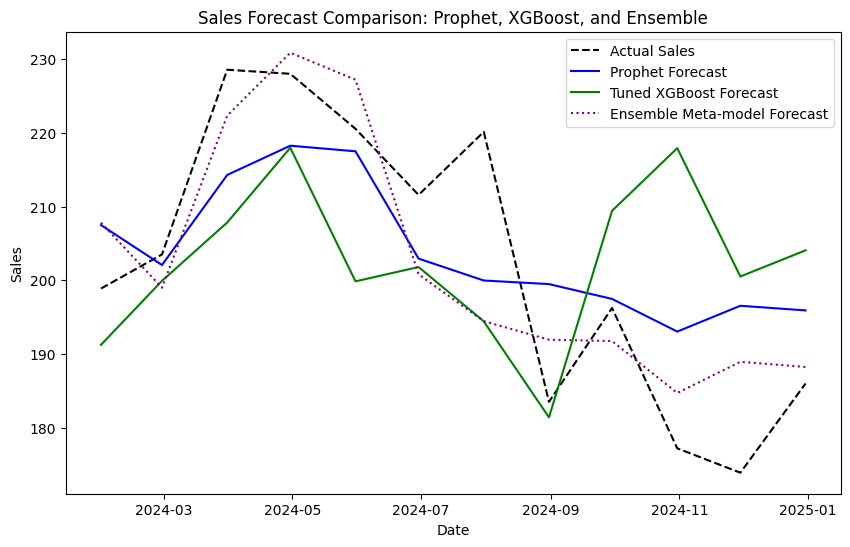

Ensemble Meta-model Forecast MAPE: 4.28%


In [ ]:
!pip install xgboost==1.7.5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
import xgboost.sklearn as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

# --- Step 1: Generate Synthetic Oncology Sales Data ---

# Set parameters for synthetic data
np.random.seed(42)
months = pd.date_range(start="2020-01-01", end="2024-12-01", freq='MS')

# Generate synthetic data for oncology sales
sales_data = pd.DataFrame({
    'Date': months,
    'Region': np.random.choice(['North America', 'Europe', 'Asia'], size=len(months)),
    'Sales': np.random.poisson(lam=200, size=len(months)) + 10 * np.sin(np.arange(len(months)) / 6),
    'Competitor_Launch': np.random.choice([0, 1], size=len(months), p=[0.9, 0.1]),
    'Incidence_Rate': np.random.normal(loc=15, scale=5, size=len(months)),
    'Seasonality': 10 * np.sin(2 * np.pi * (months.month - 1) / 12)
})

# Adjust sales based on competitor and seasonality
sales_data['Sales'] += sales_data['Seasonality'] - 10 * sales_data['Competitor_Launch']
sales_data['Sales'] = sales_data['Sales'].clip(lower=0)

# Save the synthetic oncology sales data
sales_data.to_csv('synthetic_oncology_sales.csv', index=False)

# --- Step 2: Generate Synthetic Competitor Activity Data ---

# Set parameters for competitor activity data
competitor_activity_data = pd.DataFrame({
    'Date': months,
    'Competitor': np.random.choice(['Competitor A', 'Competitor B', 'Competitor C', 'No Competitor'], size=len(months), p=[0.2, 0.3, 0.2, 0.3]),
    'Activity_Type': np.random.choice(['Pricing Change', 'Product Launch', 'Marketing Campaign','No Activity'], size=len(months), p=[0.2, 0.2, 0.2, 0.4]),
    'Region': np.random.choice(['North America', 'Europe', 'Asia'], size=len(months)),
    'Impact_Score': np.random.randint(low=0, high=10, size=len(months))  # Score representing impact (0-10)
})

# Save the synthetic competitor activity data
competitor_activity_data.to_csv('competitor_activity.csv', index=False)

# --- Step 3: Data Integration and Feature Engineering ---

# Load the datasets
sales_data = pd.read_csv('synthetic_oncology_sales.csv', parse_dates=['Date'], index_col='Date')
competitor_activity_data = pd.read_csv('competitor_activity.csv', parse_dates=['Date'], index_col='Date')

# Aggregate sales data to monthly
sales_data = sales_data.resample('ME').sum()

# Create Competitor_Launch from competitor activity data
competitor_activity_data['Competitor_Launch'] = competitor_activity_data['Activity_Type'].apply(lambda x: 1 if x == 'Product Launch' else 0)

# Resample Competitor_Launch to monthly frequency
sales_data['Competitor_Launch'] = competitor_activity_data['Competitor_Launch'].resample('ME').sum().fillna(0)

# --- Step 4: External Factors ---

# Generate synthetic external factors (GDP growth, healthcare spending)
np.random.seed(42)
gdp_growth = np.random.normal(loc=3, scale=1, size=len(sales_data))  # Hypothetical GDP growth (in %)
healthcare_spending = np.random.normal(loc=5, scale=2, size=len(sales_data))  # Hypothetical healthcare spending (in %)

# Add external regressors to the sales data
sales_data['gdp_growth'] = gdp_growth
sales_data['healthcare_spending'] = healthcare_spending

# Prepare data for Prophet
prophet_data = sales_data.reset_index().rename(columns={'Date': 'ds', 'Sales': 'y', 'Competitor_Launch': 'competitor', 'gdp_growth': 'gdp', 'healthcare_spending': 'healthcare'})

# --- Step 5: Prophet Model ---

prophet_model = Prophet()
prophet_model.add_regressor('competitor')
prophet_model.add_regressor('gdp')
prophet_model.add_regressor('healthcare')

# Fit the Prophet model
prophet_model.fit(prophet_data)

# Create future dataframe (forecasting next 12 months)
# future = prophet_model.make_future_dataframe(prophet_data, periods=12, freq='M')  # Original line causing the error
future = prophet_model.make_future_dataframe(periods=12, freq='ME')  # Corrected line
# Add future values for external regressors
last_month = sales_data.iloc[-1]
future['competitor'] = np.tile(last_month['Competitor_Launch'], len(future))
future['gdp'] = np.tile(last_month['gdp_growth'], len(future))
future['healthcare'] = np.tile(last_month['healthcare_spending'], len(future))

# Generate forecast
prophet_forecast = prophet_model.predict(future)


# --- Step 6: XGBoost Model ---

# Prepare data for XGBoost model
xgb_data = sales_data[['Competitor_Launch', 'gdp_growth', 'healthcare_spending']].copy()
xgb_data['Sales'] = sales_data['Sales']

# Split the data into training and testing sets
X = xgb_data[['Competitor_Launch', 'gdp_growth', 'healthcare_spending']]
y = xgb_data['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.9, colsample_bytree=0.9)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict with the trained XGBoost model
xgb_predictions_tuned = xgb_model.predict(X_test)
# --- Step 7: Model Evaluation ---

# Prophet model evaluation (MAPE)
actuals = sales_data['Sales'][-12:]
prophet_predicted = prophet_forecast['yhat'][-12:]
prophet_mape = mape(actuals, prophet_predicted)
print(f"Prophet Forecast MAPE: {prophet_mape:.2%}")

# XGBoost model evaluation (MAPE)
xgb_mape_tuned = mape(y_test, xgb_predictions_tuned)
print(f"Tuned XGBoost Forecast MAPE: {xgb_mape_tuned:.2%}")

# --- Step 8: Ensemble Modeling (Meta-Model) ---

# Prepare features for the meta-model (combine predictions from Prophet and XGBoost)
meta_features = pd.DataFrame({
    'prophet_pred': prophet_predicted,
    'xgb_pred': xgb_predictions_tuned
})

# Train a simple linear regression meta-model
meta_model = LinearRegression()
meta_model.fit(meta_features, actuals)

# Make final ensemble predictions using the meta-model
final_predictions = meta_model.predict(meta_features)

# Plot the results for both models and ensemble
plt.figure(figsize=(10, 6))
plt.plot(sales_data.index[-12:], actuals, label='Actual Sales', color='black', linestyle='--')
plt.plot(sales_data.index[-12:], prophet_predicted, label='Prophet Forecast', color='blue')
plt.plot(sales_data.index[-12:], xgb_predictions_tuned, label='Tuned XGBoost Forecast', color='green')
plt.plot(sales_data.index[-12:], final_predictions, label='Ensemble Meta-model Forecast', color='purple', linestyle='dotted')
plt.legend()
plt.title('Sales Forecast Comparison: Prophet, XGBoost, and Ensemble')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Calculate MAPE for the final ensemble model
ensemble_mape_meta = mape(actuals, final_predictions)
print(f"Ensemble Meta-model Forecast MAPE: {ensemble_mape_meta:.2%}")

